In [1]:
import pandas as pd
import numpy as np
from PythonFunctions import wrangle, scale, explore, cluster, evaluate
import warnings
warnings.filterwarnings("ignore")

## Wrangle 

In [2]:
zillow = wrangle.get_all_zillow_data()
zillow = zillow.sort_values('transactiondate').drop_duplicates('parcelid',keep='last')

In [3]:
zillow.shape

(77381, 69)

In [4]:
col, row = wrangle.get_nulls(zillow)

<class 'pandas.core.series.Series'>


In [5]:
#drop any col missing 30% of its data
zillow = wrangle.drop_null_columns(zillow,30)

<class 'pandas.core.series.Series'>


In [6]:
#drop any row missing 70% of its data
zillow = wrangle.drop_null_rows(zillow, 70)

In [7]:
#drop remaining data
zillow = zillow.dropna()
zillow = zillow.reset_index(drop=True)

In [8]:
zillow.isna().sum().sum()

0

In [9]:
zillow.shape

(64065, 30)

In [10]:
#for i in zillow.columns:
    #print(zillow[i].value_counts())

### Feature Engineering 
- extracted month from transactiondate
- created tax rate based on taxdollarvaluecnt and tax amount
- converted taxdollarvaluecnt to a logbase10 float
- added columns for closest city to the house and distance from said city(originally in miles)

In [11]:
zillow = wrangle.zillow_engineering(zillow)

In [12]:
zillow = wrangle.get_city_and_distance(zillow)

In [62]:
train ,closestcityte, test = wrangle.split_for_model(zillow)
train_scaled, validate_scaled, test_scaled = scale.scale_data(train, validate, test, 'MinMax',\
                                                              to_scale=['log10price','calculatedfinishedsquarefeet','latitude','longitude',\
                                                                        'lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt',\
                                                                        'taxvaluedollarcnt', 'taxamount', 'landtaxvaluedollarcnt','taxrate','finishedsquarefeet12', 'distancefromcity'])

train(35876, 35),validate(15376, 35),test(12813, 35)


## Explore

### Exploring Variables in relation to Target = Log Error

In [63]:
cont_vars = ['logerror','log10price','calculatedfinishedsquarefeet','latitude','longitude','lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt',\
             'taxvaluedollarcnt', 'taxamount', 'landtaxvaluedollarcnt','taxrate','finishedsquarefeet12', 'transactionmonth','bathroomcnt','bedroomcnt' , 'regionidzip', 'distancefromcity']
target = 'logerror'

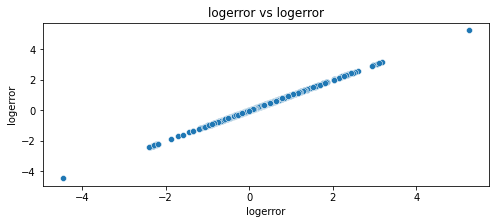

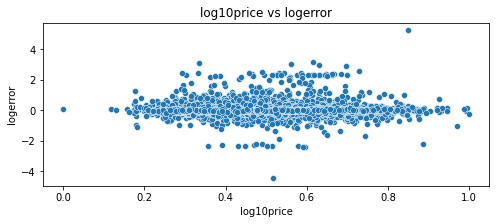

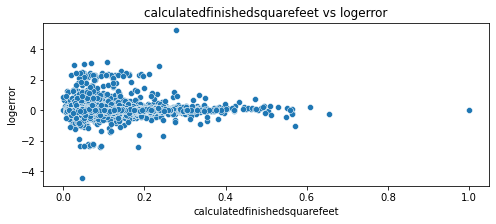

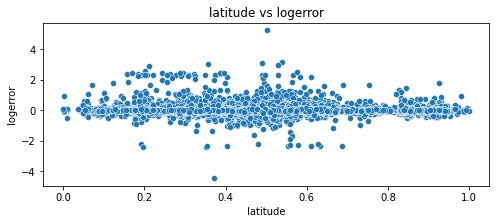

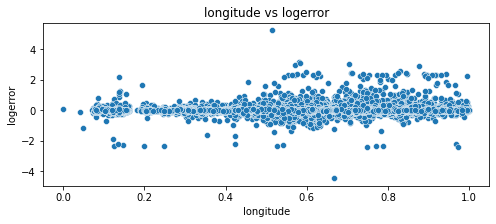

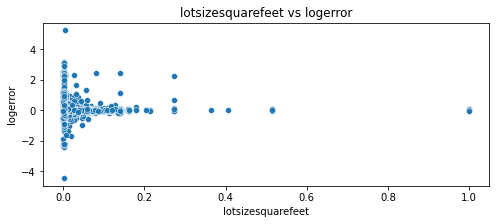

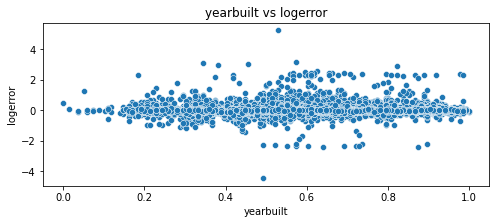

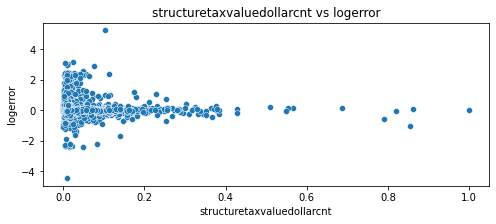

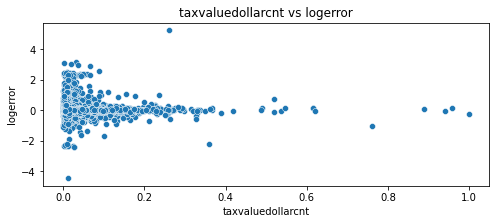

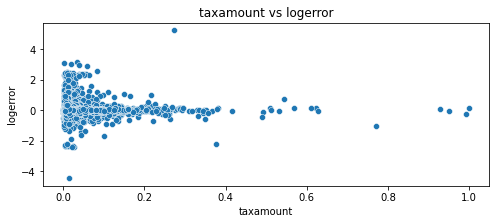

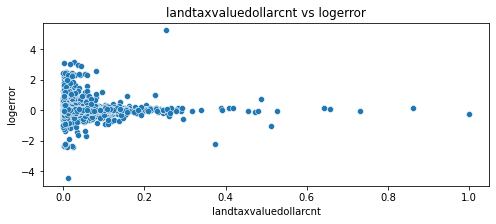

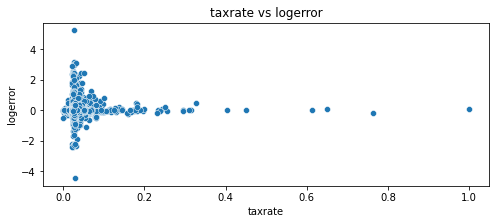

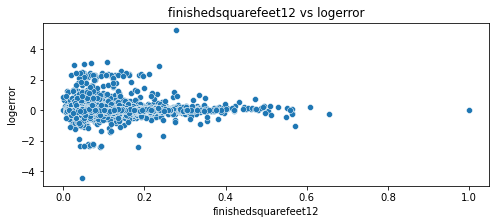

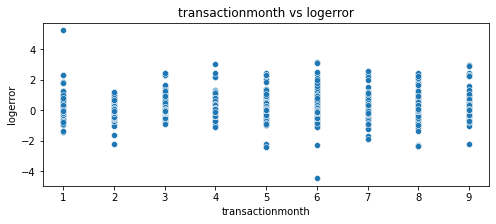

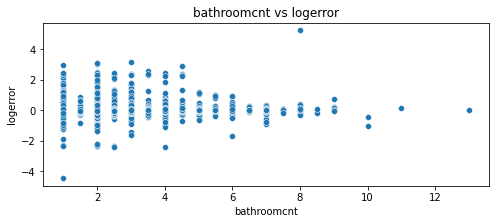

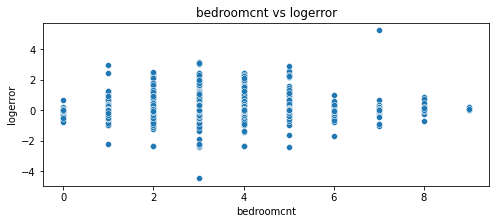

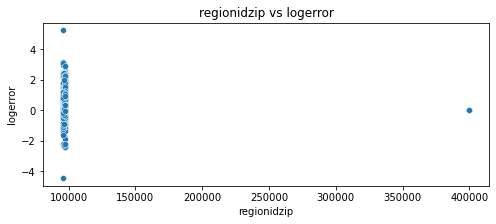

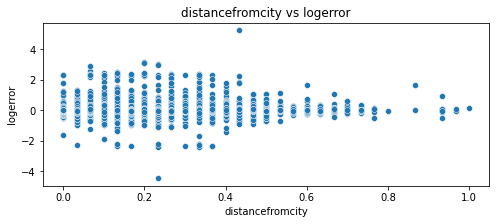

In [64]:
explore.compare_to_target(train_scaled[cont_vars], target)

## Take Aways
- Pricing, Size, Age, and Location play  big rolls in log error
- The more houses are similar to eachother in terms of these 4 main topics , the harder it is to predict there price accurately
    * Why? maybe our data needs to know more about its position?
- we will look more into age vs price vs size vs location , cluster these and see if we can spot trends on log error

## Clustering 
### Target = Logerror 

In [179]:
X = train_scaled[['logerror']]
X = cluster.show_cluster(X, 4, 'logbin', hide=True)
train_scaled['logbin'] = X['logbin']

### Price

In [183]:
X = train_scaled[['taxvaluedollarcnt','structuretaxvaluedollarcnt','taxamount']]
X = cluster.show_cluster(X, 4, 'price', hide=True)
train_scaled['price'] = X['price']

### Size

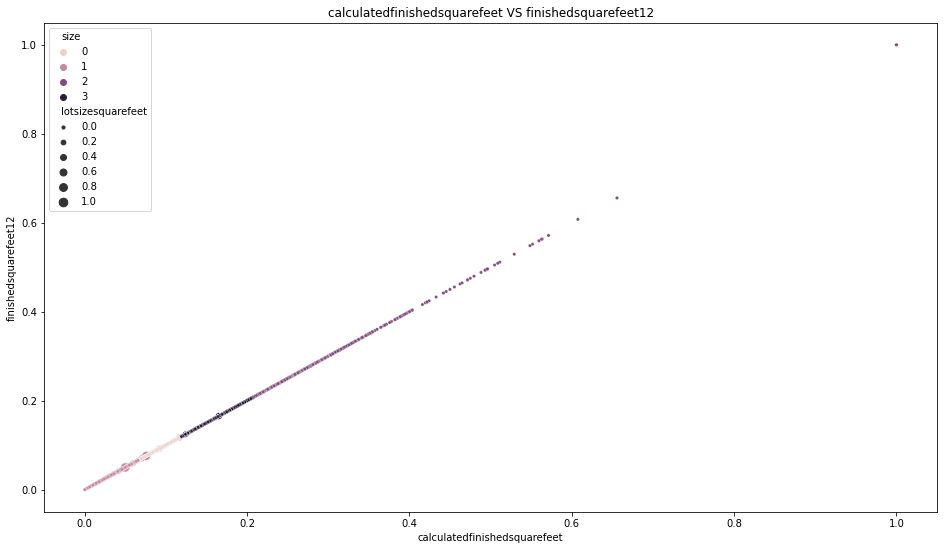

In [187]:
X = train_scaled[['calculatedfinishedsquarefeet','finishedsquarefeet12','lotsizesquarefeet']]
X = cluster.show_cluster(X, 4, 'size', size='lotsizesquarefeet', hide= False)
train_scaled['size'] = X['size']

### Age

In [150]:
X = train_scaled[['yearbuilt']]
X = cluster.show_cluster(X, 4, 'age', hide=True)
train_scaled['age'] = X['age']

### Location

In [151]:
X = train_scaled[['distancefromcity']]
X = cluster.show_cluster(X, 4, 'distance', hide=True)
train_scaled['distance'] = X['distance']

## Cross Referencing our Big 4

### Size vs Price

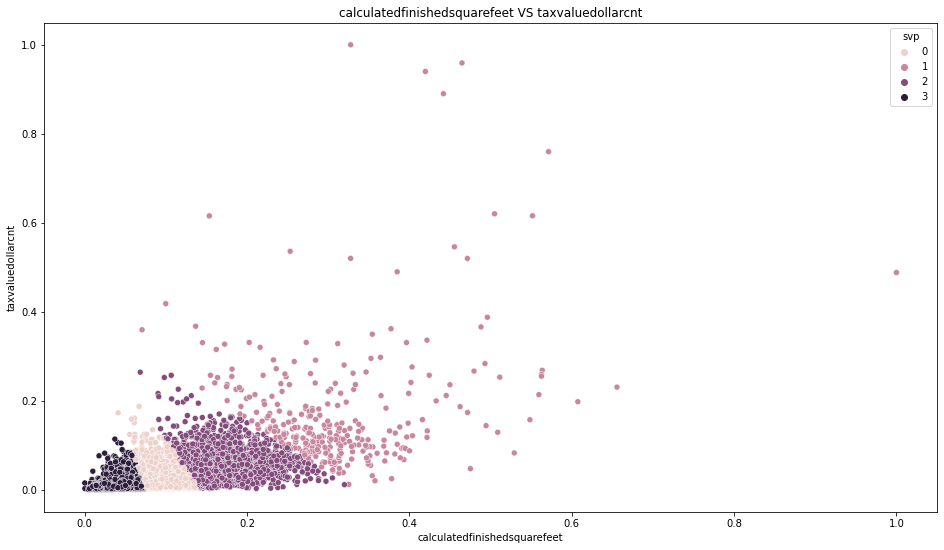

In [180]:
X = train_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
X = cluster.show_cluster(X, 4, 'svp')
train_scaled['svp'] = X['svp']

### Price vs Age

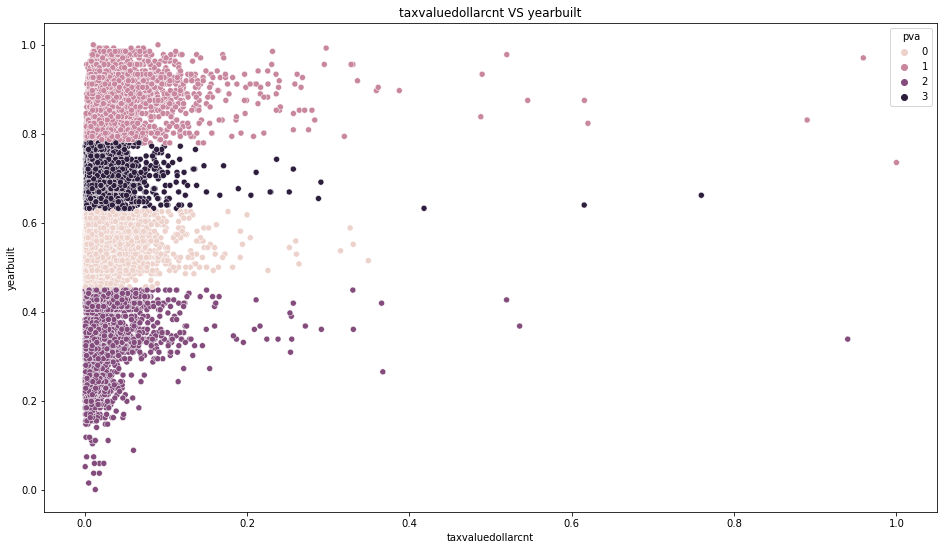

In [181]:
X = train_scaled[['taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 4, 'pva', hide=False)
train_scaled['pva'] = X['pva']


### Age vs Size

In [154]:
X = train_scaled[[ 'yearbuilt', 'calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 4, 'avs', hide=True)
train_scaled['avs'] = X['avs']

### Size vs Distance

In [155]:
X = train_scaled[['calculatedfinishedsquarefeet','distancefromcity']]
X = cluster.show_cluster(X, 4, 'svd', hide=True)
train_scaled['svd'] = X['svd']

### Price vs Distance

In [156]:
X = train_scaled[['taxvaluedollarcnt','distancefromcity']]
X = cluster.show_cluster(X, 4, 'pvd', hide=True)
train_scaled['pvd'] = X['pvd']

### Age vs Distance

In [157]:
X = train_scaled[['yearbuilt','distancefromcity']]
X = cluster.show_cluster(X, 4, 'avd', hide=True)
train_scaled['avd'] = X['avd']

## All 4

### Size vs Price vs Age vs Location

In [158]:
X = train_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt', 'distancefromcity']]
X = cluster.show_cluster(X, 4, 'all', 'yearbuilt', hide=True)
train_scaled['all'] = X['all']

### Find Trend

In [177]:
X = train_scaled[['logerror']]
X = cluster.show_cluster(X, 4, 'logbin',hide= True)
train_scaled['logbin'] = X['logbin']

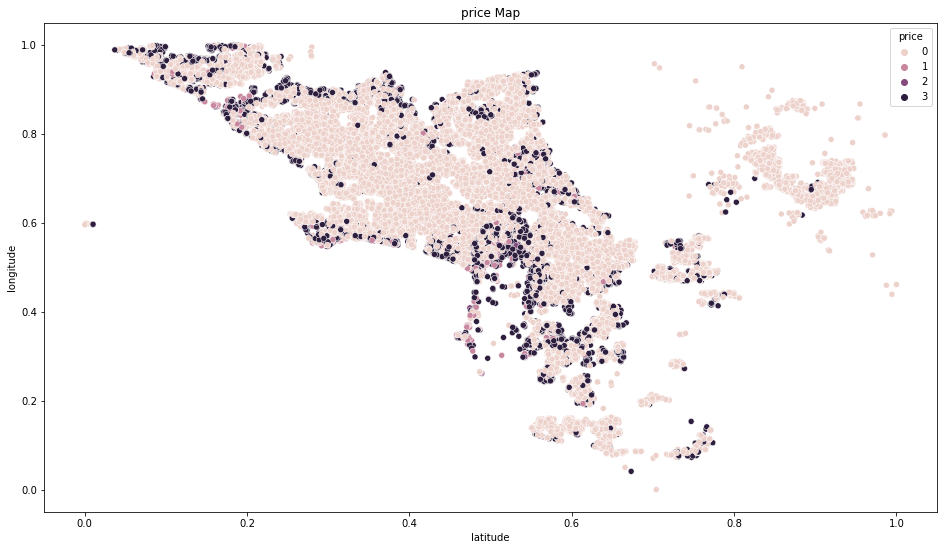

In [175]:
#cluster.map_clusters(train_scaled, 'price')
cluster.map_clusters(train_scaled[train_scaled['price', 'price')

## Major Takeaway 
- Majority of the houses that had the most log error are either cheaper or smaller

- There are more cheaper and smaller houses in the dataset, do they need there own model to be accurate?

### Next steps
1. Do different price markets have different drivers for predicting log error
2. Do the cluster columns created help or hinder predicting log error? 
3. Do different markets need to have an entirely different models in order to be accurate in predictiong log error.

In [47]:
#add clusters to validate and test dataframes

In [48]:
#---Validate---
X = validate_scaled[['logerror']]
X = cluster.show_cluster(X, 4, 'logbin', hide=True)
validate_scaled['logbin'] = X['logbin']

X = validate_scaled[['taxvaluedollarcnt']]
X = cluster.show_cluster(X, 4, 'price',hide= True)
validate_scaled['price'] = X['price']

X = validate_scaled[['calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 4, 'size',hide= True)
validate_scaled['size'] = X['size']

X = validate_scaled[['yearbuilt']]
X = cluster.show_cluster(X, 4, 'age',hide= True)
validate_scaled['age'] = X['age']

X = validate_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
X = cluster.show_cluster(X, 4, 'svp',hide= True)
validate_scaled['svp'] = X['svp']

X = validate_scaled[['taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 4, 'pva',hide= True)
validate_scaled['pva'] = X['pva']

X = validate_scaled[[ 'yearbuilt', 'calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 4, 'avs',hide= True)
validate_scaled['avs'] = X['avs']

X = validate_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 4, 'all',size = 'yearbuilt',hide= True)
validate_scaled['all'] = X['all']

#---Test---
X = test_scaled[['logerror']]
X = cluster.show_cluster(X, 4, 'logbin', hide=True)
test_scaled['logbin'] = X['logbin']

X = test_scaled[['taxvaluedollarcnt']]
X = cluster.show_cluster(X, 4, 'price',hide= True)
test_scaled['price'] = X['price']

X = test_scaled[['calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 4, 'size',hide= True)
test_scaled['size'] = X['size']

X = test_scaled[['yearbuilt']]
X = cluster.show_cluster(X, 4, 'age',hide= True)
test_scaled['age'] = X['age']

X = test_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
X = cluster.show_cluster(X, 4, 'svp',hide= True)
test_scaled['svp'] = X['svp']

X = test_scaled[['taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 4, 'pva',hide= True)
test_scaled['pva'] = X['pva']

X = test_scaled[[ 'yearbuilt', 'calculatedfinishedsquarefeet']]
X = cluster.show_cluster(X, 4, 'avs',hide= True)
test_scaled['avs'] = X['avs']

X = test_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt']]
X = cluster.show_cluster(X, 4, 'all',size = 'yearbuilt',hide= True)
test_scaled['all'] = X['all']

In [49]:
#drop non-numerical columns and id columns for modeling, drop logbin for modeling

In [50]:
train_scaled = train_scaled.drop(columns=['propertylandusetypeid','parcelid','id','id.1',\
                                          'transactiondate','propertycountylandusecode',\
                                          'propertylandusedesc'])
validate_scaled = validate_scaled.drop(columns=['propertylandusetypeid','parcelid','id','id.1',\
                                          'transactiondate','propertycountylandusecode',\
                                          'propertylandusedesc'])
test_scaled = test_scaled.drop(columns=['propertylandusetypeid','parcelid','id','id.1',\
                                          'transactiondate','propertycountylandusecode',\
                                          'propertylandusedesc'])

### 1. Does each housing market prioritize different drivers?

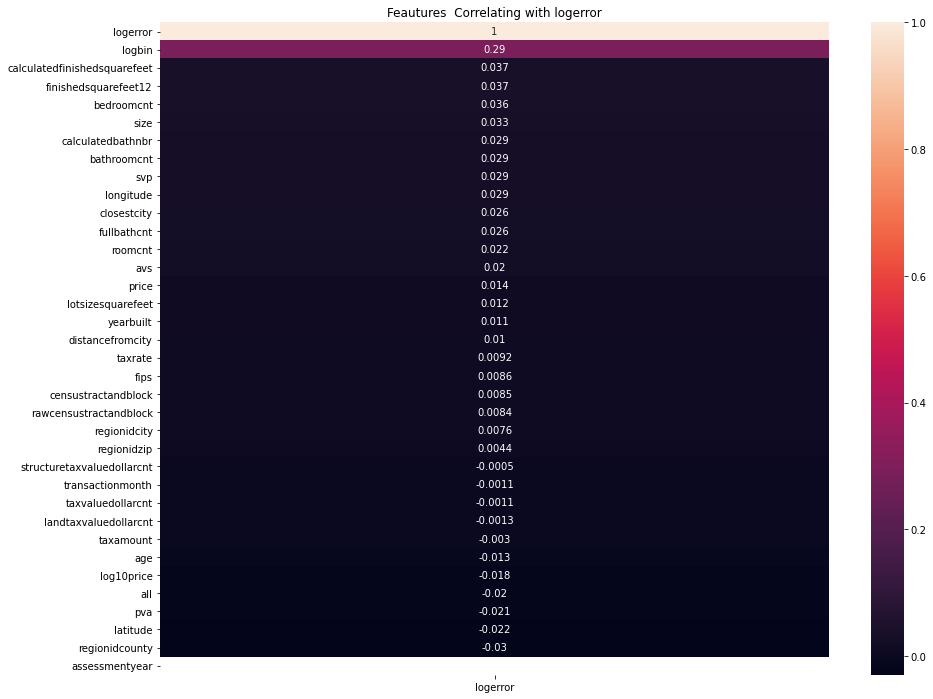

<AxesSubplot:title={'center':'Feautures  Correlating with logerror'}>

In [60]:
explore.get_heatmap(train_scaled, 'logerror')

#### Drivers

In [52]:
X_train = train_scaled.drop(columns=['logerror'])
y_train = train_scaled[['logerror','price']]

X_validate = validate_scaled.drop(columns=['logerror'])
y_validate = validate_scaled[['logerror','price']]

X_test = test_scaled.drop(columns=['logerror'])
y_test = test_scaled[['logerror','price']]

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

#### K-Best and RFE

In [53]:
kbest = evaluate.select_kbest(X_train, y_train,8 )
kbest0 = evaluate.select_kbest(evaluate.get_price(X_train,0),evaluate.get_price(y_train,0), 3)
kbest1 = evaluate.select_kbest(evaluate.get_price(X_train,1),evaluate.get_price(y_train,1), 3)
kbest2 = evaluate.select_kbest(evaluate.get_price(X_train,2),evaluate.get_price(y_train,2), 3)


In [54]:
rfe = evaluate.select_rfe(X_train, y_train,8)
rfe0 = evaluate.select_rfe(evaluate.get_price(X_train,0),evaluate.get_price(y_train,0), 1)
rfe1 = evaluate.select_rfe(evaluate.get_price(X_train,1),evaluate.get_price(y_train,1), 3)
rfe2 = evaluate.select_rfe(evaluate.get_price(X_train,2),evaluate.get_price(y_train,2), 3)